# Copula-Diffusion Hybrid Model

This notebook implements the mathematical framework described in `research/copula_dependence/README.md`:

1. Fetch and organize historical lottery draw and betting amount data from 2025 to present.
2. Model marginal dependencies using rank transformation (pseudo-observations) and Gaussian Copula.
3. Design and construct the diffusion matrix $D$ to simulate the dynamic evolution of number frequencies over discrete periods.
4. Simulate future frequency evolution in discrete time and sample predicted numbers.

## 1. Data Acquisition and Structure Overview

This section automatically fetches historical Hong Kong Mark Six lottery draw data from 2025 to the present, extracting the main ball numbers and betting amounts (`totalInvestment`).

- Each record includes the draw number, draw date, main ball numbers (`drawnNo`), extra ball number (`xDrawnNo`), and betting amount (`totalInvestment`), among other fields.
- Only records with complete main ball numbers and betting amounts are retained; the main balls are organized into an n x 6 array (either sorted or in original order) and sorted by draw date.
- Next, we will use rank-based pseudo observations to construct a Copula, and build the diffusion matrix as described in the README.

In [1]:
# Import necessary packages and data acquisition (can be executed directly)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import sys
import os

# If the project path is not in sys.path, temporarily add the upper directory for helper import
sys.path.append(os.path.join(os.getcwd(), "..", ".."))

# Get data from the project's fetch function
from get_lottery_data import get_lottery_data

# Fetch data (from 2025-01-01 to present)
print("Fetching historical draw data...")
data = get_lottery_data(start_date="2025-01-01", end_date=pd.Timestamp.today().strftime("%Y-%m-%d"))
print(f"Fetched {len(data)} draw records")

# View the first record to confirm data format
try:
    print("Sample record (first):", data[0])
except Exception:
    print("Data is not list-like or sampling failed; check get_lottery_data return format")

# Set plot style
%matplotlib inline
plt.rcParams.update({"figure.figsize": (8, 4), "font.size": 10})

Fetching historical draw data...
Date range is larger than 3 months, splitting the request from 2025-01-01 00:00:00 to 2025-10-26 00:00:00
Fetching data from 20250101 to 20250401
Fetching data from 20250402 to 20250701
Fetching data from 20250702 to 20250930
Fetching data from 20251001 to 20251026
Fetched 115 draw records
Sample record (first): {'id': '2025115N', 'year': '2025', 'no': 115, 'openDate': '2025-10-23+08:00', 'closeDate': '2025-10-25T21:15:00+08:00', 'drawDate': '2025-10-25+08:00', 'status': 'Result', 'snowballCode': '', 'snowballName_en': '', 'snowballName_ch': '', 'lotteryPool': {'sell': False, 'status': 'Payout', 'totalInvestment': '75643571', 'jackpot': '31940095', 'unitBet': 10, 'estimatedPrize': '', 'derivedFirstPrizeDiv': '40000000', 'lotteryPrizes': [{'type': 1, 'winningUnit': 0, 'dividend': '0'}, {'type': 2, 'winningUnit': 20, 'dividend': '1424430'}, {'type': 3, 'winningUnit': 1170, 'dividend': '64930'}, {'type': 4, 'winningUnit': 2565, 'dividend': '9600'}, {'type'

In [2]:
# Organize data: extract main balls and betting amount, sort, and return DataFrame

def extract_main_numbers_and_bet(data):
    records = []
    for d in data:
        try:
            main_numbers = d['drawResult']['drawnNo']
            bet_str = d['lotteryPool'].get('totalInvestment', None)
            bet = int(bet_str) if bet_str not in (None, '', []) else None
            date = pd.to_datetime(d['drawDate'][:10])
            if len(main_numbers) == 6 and bet is not None:
                # Sort main balls (if not already sorted, sort for comparison)
                main_sorted = sorted(main_numbers)
                records.append({'date': date, 'main_numbers': main_sorted, 'bet': bet})
        except Exception:
            continue
    df = pd.DataFrame(records)
    df = df.sort_values('date').reset_index(drop=True)
    return df

# Execute organization
df = extract_main_numbers_and_bet(data)
print(f"Obtained {len(df)} valid periods of data, example:")
print(df.head(3))

# Expand main balls to numpy array for processing
main_numbers = np.array(df['main_numbers'].tolist())  # shape: (n, 6)
n, d = main_numbers.shape
print(f"n={n}, d={d}")

Obtained 115 valid periods of data, example:
        date             main_numbers        bet
0 2025-01-02  [9, 23, 42, 44, 45, 46]  241793017
1 2025-01-07  [8, 13, 18, 23, 31, 47]  328821743
2 2025-01-09  [1, 19, 28, 33, 35, 41]   41152640
n=115, d=6


## 2. Bet Amount Normalization and Parameter Setup

This section normalizes the bet amount (`totalInvestment`) using logarithmic transformation, and sets up the parameters required for the diffusion matrix and Copula dependency adjustment.

In [3]:
# 3. Bet Amount Normalization and Model Parameter Setup
bets = df['bet'].values
b_norm = np.log(bets / np.mean(bets))  # Log normalization
print(f"Bet amount normalization example: {b_norm[:3]}")

# Tunable hyperparameters (recommended initial values per README)
eta = 5.0    # Gaussian kernel width
alpha = 0.5  # Copula correlation weight
kappa = 0.2  # Bet amount amplification weight
gamma = 0.0  # Copula correlation bias
beta = 0.5   # Bet amount adjustment for Copula correlation
sigma = 0.3  # Dependency random perturbation standard deviation

# Additional settings: random seed and prediction horizon
np.random.seed(42)
predict_horizon = 5  # Predict next 5 periods

Bet amount normalization example: [ 1.32409664  1.63153037 -0.44669734]


## 3. Copula Marginal Transformation and Correlation Matrix Estimation

In this section, each period's main ball numbers are transformed using rank-based pseudo-observations, and the correlation matrix of the Gaussian Copula is estimated.

In [4]:
# 2. Copula marginal transformation and correlation matrix estimation
# For each main ball position, perform rank transformation and add small jitter, then use Gaussian Copula to build the correlation matrix
from scipy.stats import rankdata, norm
np.random.seed(42)

delta = 0.01
u = np.zeros((n, d), dtype=float)
for j in range(d):
    ranks = rankdata(main_numbers[:, j])
    u[:, j] = ranks / (n + 1) + np.random.uniform(-delta, delta, n)

# Avoid extreme values causing norm.ppf to produce inf
eps = 1e-6
u = np.clip(u, eps, 1 - eps)
z = norm.ppf(u)

# If z contains NaN/infinity, stop
if np.isnan(z).any() or np.isinf(z).any():
    raise RuntimeError('NaN or infinity found in z, please check u and delta')

# Estimate correlation matrix: first get sample covariance of z, then convert to correlation matrix
S = np.cov(z, rowvar=False)
# Try Ledoit-Wolf shrinkage (if sklearn is available) for improved stability, otherwise use sample covariance
try:
    from sklearn.covariance import LedoitWolf
    lw = LedoitWolf().fit(z)
    Sigma = lw.covariance_
    # Convert covariance to correlation
    Dsqrt = np.sqrt(np.diag(Sigma))
    corr = Sigma / np.outer(Dsqrt, Dsqrt)
    corr[np.isnan(corr)] = 0.0
except Exception:
    Sigma = S
    Dsqrt = np.sqrt(np.diag(Sigma))
    corr = Sigma / np.outer(Dsqrt, Dsqrt)
    corr[np.isnan(corr)] = 0.0

print('Estimation complete: Copula correlation matrix (first 3x3)')
print(np.round(corr[:3, :3], 3))

Estimation complete: Copula correlation matrix (first 3x3)
[[1.    0.716 0.497]
 [0.716 1.    0.679]
 [0.497 0.679 1.   ]]


In [5]:
# 4. Diffusion Matrix D Construction and Frequency Initialization (Improved: Using Number-to-Number Co-occurrence Correlation)
nums = 49
# Frequency initialization: Estimate f_0 using historical occurrence counts
f0 = np.zeros(nums)
for row in main_numbers:
    for k in row:
        f0[k-1] += 1
f0 = f0 / f0.sum()
print(f"Initial frequency distribution for first 10 numbers: {np.round(f0[:10], 3)}")

# Build number-period binary occurrence matrix X (n x 49), used to estimate number-to-number correlation
X = np.zeros((n, nums), dtype=int)
for i, row in enumerate(main_numbers):
    for k in row:
        X[i, k-1] = 1

# Safe version of corr calculation: Avoid nan or warning when a column is constant (std=0)
def safe_corrcoef(mat):
    mat = np.asarray(mat, dtype=float)
    p = mat.shape[1]
    mean = mat.mean(axis=0)
    std = mat.std(axis=0, ddof=0)
    corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        for j in range(p):
            if std[i] == 0 or std[j] == 0:
                corr[i, j] = 0.0
            else:
                cov = ((mat[:, i] - mean[i]) * (mat[:, j] - mean[j])).mean()
                corr[i, j] = cov / (std[i] * std[j])
    return corr

# Calculate number-to-number correlation matrix using safe_corrcoef
rho_num = safe_corrcoef(X)
print('Number-to-number correlation matrix (first 5x5):')
print(np.round(rho_num[:5, :5], 3))

# If eta / alpha are not defined (user may not have run parameter cell), provide reasonable defaults to avoid NameError
if 'eta' not in globals():
    eta = 5.0
if 'alpha' not in globals():
    alpha = 0.5

# Construct base weighted Laplacian D_base (without bet amplification term, bet amount is added during evolution)
D_base = np.zeros((nums, nums))
grid = np.arange(1, nums+1)
for k in range(nums):
    for j in range(nums):
        if k == j:
            continue
        dist = (grid[k] - grid[j])**2
        rho_kj = rho_num[k, j]
        w = np.exp(-dist / (2 * eta**2)) * (1 + alpha * abs(rho_kj))
        D_base[k, j] = -w
        D_base[k, k] += w

# Check properties of D_base: Row sums should be approximately 0
row_sums = np.round(D_base.sum(axis=1), 10)
print(f"D_base row sums (first 10): {row_sums[:10]}")
print("D_base first 2x2:")
print(np.round(D_base[:2, :2], 4))

# Assign D_base to D (for compatibility, subsequent evolution will use time-varying D_t)
D = D_base.copy()

Initial frequency distribution for first 10 numbers: [0.019 0.01  0.019 0.019 0.017 0.025 0.019 0.014 0.014 0.01 ]
Number-to-number correlation matrix (first 5x5):
[[ 1.     0.139  0.046  0.133 -0.122]
 [ 0.139  1.     0.024  0.139 -0.087]
 [ 0.046  0.024  1.     0.046  0.058]
 [ 0.133  0.139  0.046  1.    -0.122]
 [-0.122 -0.087  0.058 -0.122  1.   ]]
D_base row sums (first 10): [-0. -0.  0. -0. -0. -0.  0.  0.  0. -0.]
D_base first 2x2:
[[ 6.0509 -1.0482]
 [-1.0482  7.0063]]


In [6]:
# 5. Parameter Estimation (Fast Method: grid-search alpha + closed-form kappa)
# We use each period's single-period frequency vector f_hist[t] = X[t]/6 (indicator for 6 numbers per period),
# and the model: y_t = f_{t+1} - f_t ≈ dt * (1 + kappa * b_norm[t]) * (D_base(alpha) @ f_t)
# By grid-searching alpha, and for each alpha using closed-form estimation for kappa (linear least squares method),
# select the (alpha, kappa) that minimizes SSE.

import numpy as np
from scipy.optimize import minimize

# Function to construct D_base (consistent with notebook's D_base construction)
def build_D_base_from_alpha(alpha_val, eta_val=5.0):
    nums_local = nums
    grid = np.arange(1, nums_local+1)
    D_tmp = np.zeros((nums_local, nums_local))
    for k in range(nums_local):
        for j in range(nums_local):
            if k == j:
                continue
            dist = (grid[k] - grid[j])**2
            rho_kj = rho_num[k, j]
            w = np.exp(-dist / (2 * eta_val**2)) * (1 + alpha_val * abs(rho_kj))
            D_tmp[k, j] = -w
            D_tmp[k, k] += w
    return D_tmp

# Prepare historical single-period frequency f_hist (indicator/6 for each period)
T = X.shape[0]
f_hist = np.zeros((T, nums))
for t in range(T):
    f_hist[t] = X[t] / 6.0

# y_t and s_t (s_t = D_base @ f_t) used to estimate kappa
# Expand alpha search range to avoid boundary solutions being too limited
alpha_grid = np.linspace(0.0, 2.0, 21)
best = {'alpha': None, 'kappa': None, 'sse': np.inf}
eta_val = eta  # use current eta
for a in alpha_grid:
    D_try = build_D_base_from_alpha(a, eta_val=eta_val)
    # build regression components
    Ys = []
    Bs = []
    Svecs = []
    for t in range(T-1):
        f_t = f_hist[t]
        f_tp1 = f_hist[t+1]
        y = (f_tp1 - f_t).ravel()
        s = (D_try @ f_t).ravel()
        b = b_norm[t]
        Ys.append(y - s)  # left-hand for kappa * (b * s)
        Svecs.append((b * s))
    Ys = np.concatenate(Ys)
    Svecs = np.concatenate(Svecs)
    denom = np.dot(Svecs, Svecs)
    if denom == 0:
        kappa_hat = 0.0
    else:
        kappa_hat = np.dot(Svecs, Ys) / denom
    # compute SSE
    sse = np.sum((Ys - kappa_hat * Svecs)**2)
    if sse < best['sse']:
        best.update({'alpha': a, 'kappa': kappa_hat, 'sse': sse})

print('Parameter estimation result (fast grid-search + closed-form kappa):')
print(best)

# Save estimation results for global use
est_alpha = best['alpha']
est_kappa = best['kappa']
# Rebuild D_base for subsequent use
D_base = build_D_base_from_alpha(est_alpha, eta_val=eta_val)
D = D_base.copy()
print(f'D_base and D updated, using est_alpha={est_alpha:.3f}, est_kappa={est_kappa:.4f}')

Parameter estimation result (fast grid-search + closed-form kappa):
{'alpha': np.float64(0.0), 'kappa': np.float64(0.6931598470178951), 'sse': np.float64(2228.7081221259323)}
D_base and D updated, using est_alpha=0.000, est_kappa=0.6932


In [7]:
# 6. Copula-based sampling function
# Use position-layer Gaussian Copula (corr, d=6) to generate 6 uniform values for positions,
# Then use these uniform values as the 'quantile' for each position on the current probability vector to select numbers (eliminate already chosen numbers one by one),
# So that the dependency between positions is represented by the Copula, while number selection is still controlled by f_t.

import numpy as np
from scipy.stats import norm

def sample_six_from_probs_with_gaussian_copula(probs, corr, rng=None):
    """
    probs: length-49 array, sums to 1
    corr: (6,6) correlation matrix for positions
    Returns: sorted list of 6 distinct numbers (1-49)
    """
    if rng is None:
        rng = np.random.default_rng()
    d = corr.shape[0]
    # sample z ~ N(0, corr)
    try:
        z = rng.multivariate_normal(mean=np.zeros(d), cov=corr)
    except Exception:
        # numerical fallback: add tiny jitter to diagonal
        jitter = 1e-8
        z = rng.multivariate_normal(mean=np.zeros(d), cov=corr + np.eye(d)*jitter)
    u = norm.cdf(z)
    eps = 1e-8
    u = np.clip(u, eps, 1 - eps)

    probs = np.asarray(probs, dtype=float)
    if probs.sum() <= 0:
        probs = np.ones_like(probs) / len(probs)
    else:
        probs = probs / probs.sum()

    remaining_probs = probs.copy()  # length 49, we will zero-out chosen entries
    selected = []

    for j in range(d):
        nonzero_idx = np.flatnonzero(remaining_probs)
        if len(nonzero_idx) == 0:
            break
        # cumulative over non-zero entries only to avoid gaps
        probs_nz = remaining_probs[nonzero_idx]
        probs_nz = probs_nz / probs_nz.sum()
        cum = np.cumsum(probs_nz)
        target = u[j]
        idx = np.searchsorted(cum, target)
        if idx >= len(nonzero_idx):
            idx = len(nonzero_idx)-1
        chosen_global = nonzero_idx[idx]
        selected.append(int(chosen_global) + 1)
        remaining_probs[chosen_global] = 0.0

    # If duplicates or fewer than 6 (rare), fill uniformly among remaining
    selected = sorted(set(selected))
    if len(selected) < 6:
        remaining = [i for i in range(1, len(probs)+1) if i not in selected]
        extra_needed = 6 - len(selected)
        extra = list(rng.choice(remaining, size=extra_needed, replace=False))
        selected += extra
        selected = sorted(selected)

    return selected

# Demonstration helper: apply Copula-based sampling to existing f_preds (if present)
if 'f_preds' in globals() and 'corr' in globals():
    rng = np.random.default_rng(123)
    preds_copula = []
    for m in range(1, min(len(f_preds), 6)):
        p = f_preds[m]
        main = sample_six_from_probs_with_gaussian_copula(p, corr, rng=rng)
        extra = rng.choice(np.arange(1, nums+1), p=p)
        preds_copula.append({'period': m, 'main': main, 'extra': int(extra)})

    print('Example: Copula-based sampling results (first few periods)')
    for p in preds_copula:
        print(f"Period +{p['period']}: {p['main']} + {p['extra']}")

## 7. Frequency Evolution, Sampling Prediction, and Visualization

- Discrete-time Euler update: \( f_{t+1} = f_t + \Delta t D f_t \) (\( \Delta t = 1 \)).
- At each time step, \( f \) is clipped to non-negative values and renormalized to a probability distribution.
- Sampling strategy: Select 6 distinct numbers as main balls from \( f_t \) using a multinomial distribution (simplified), and record the extra number.
- Note: This sampling does not fully reflect the Copula's multivariate dependence (since the number space is 49-dimensional, Copula is modeled on the 6-dimensional main ball positions). For precise conditional sampling, more complex mapping or pairwise conditional sampling can be used.

D_base max |eig| = 12.533127
Prediction results (example, time-varying D_t + Copula sampling):
Period +1: [7, 11, 12, 18, 22, 23] + 19
Period +2: [18, 19, 21, 22, 32, 35] + 22
Period +3: [15, 21, 24, 29, 32, 35] + 29
Period +4: [19, 29, 32, 35, 39, 45] + 15
Period +5: [11, 13, 15, 18, 19, 32] + 11


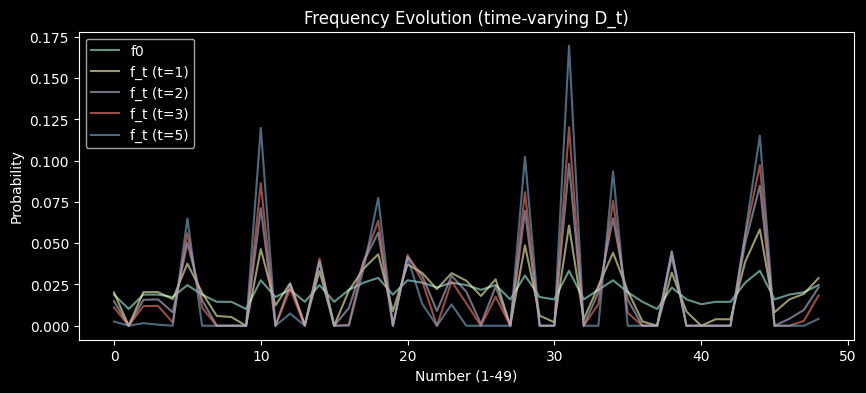

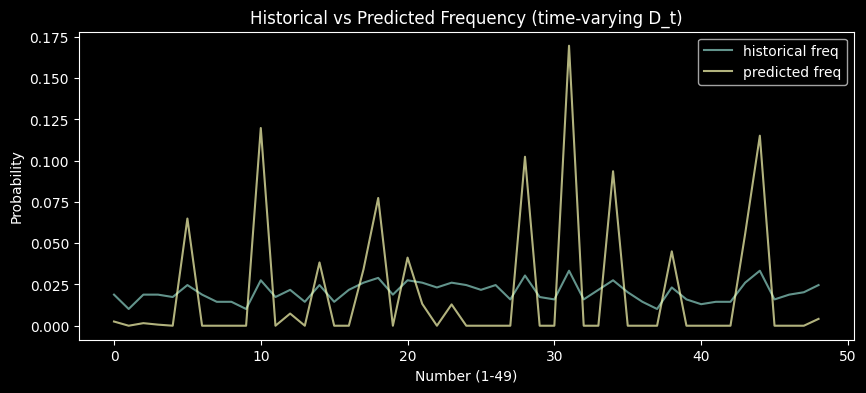

Time-varying evolution module completed.


In [8]:
# 7. Frequency Evolution, Sampling Prediction, and Visualization (time-varying D_t using b_norm)
# This cell uses D_base and each period's bet amount b_norm to generate time-varying D_t and evolve f

# Check required variables
required = ['D_base', 'f0', 'predict_horizon', 'nums', 'b_norm']
for name in required:
    if name not in globals():
        raise RuntimeError(f'Required variable {name} does not exist, please run the previous cell: {name}')

# Euler stability check: If D_base eigenvalues are too large, shorten dt
eigvals = np.linalg.eigvals(D_base)
max_abs_eig = np.max(np.abs(eigvals))
print('D_base max |eig| =', round(float(max_abs_eig), 6))

dt = 1.0
if dt * max_abs_eig >= 1.0:
    print('Warning: Euler may be unstable (dt * max|eig| >= 1). Setting dt to 0.1 to avoid numerical instability.')
    dt = 0.1

f_preds = [f0.copy()]
for m in range(predict_horizon):
    # Use historical bet amount sequence to adjust each future step; if exceeding historical periods, use last known bet amount
    idx = min(m, len(b_norm)-1)
    D_t = D_base * (1 + (est_kappa if 'est_kappa' in globals() else kappa) * b_norm[idx])
    f_next = f_preds[-1] + dt * (D_t @ f_preds[-1])
    f_next = np.maximum(f_next, 0)
    if f_next.sum() <= 0:
        f_next = np.ones_like(f_next) / len(f_next)
    else:
        f_next = f_next / f_next.sum()
    f_preds.append(f_next)

# Sampling prediction numbers (example: Copula-based)
preds = []
for m in range(1, predict_horizon+1):
    probs = f_preds[m]
    main = sample_six_from_probs_with_gaussian_copula(probs, corr)
    extra = np.random.choice(np.arange(1, nums+1), p=probs)
    preds.append({'period': m, 'main': main, 'extra': int(extra)})

print("Prediction results (example, time-varying D_t + Copula sampling):")
for p in preds:
    print(f"Period +{p['period']}: {p['main']} + {p['extra']}")

# Visualization: Initial frequency and evolution trajectory
plt.figure(figsize=(10,4))
plt.plot(f0, label='f0', alpha=0.7)
for i, f_i in enumerate(f_preds[1:], start=1):
    if i <= 3 or i == len(f_preds)-1:
        plt.plot(f_i, label=f'f_t (t={i})', alpha=0.6)
plt.xlabel('Number (1-49)')
plt.ylabel('Probability')
plt.title('Frequency Evolution (time-varying D_t)')
plt.legend()
plt.show()

# Simple PPC: Compare historical frequency and simulated frequency (last prediction period)
obs_counts = np.zeros(nums)
for row in main_numbers:
    for k in row:
        obs_counts[k-1] += 1
obs_freq = obs_counts / obs_counts.sum()

plt.figure(figsize=(10,4))
plt.plot(obs_freq, label='historical freq', alpha=0.7)
plt.plot(f_preds[-1], label='predicted freq', alpha=0.7)
plt.xlabel('Number (1-49)')
plt.ylabel('Probability')
plt.title('Historical vs Predicted Frequency (time-varying D_t)')
plt.legend()
plt.show()

print('Time-varying evolution module completed.')

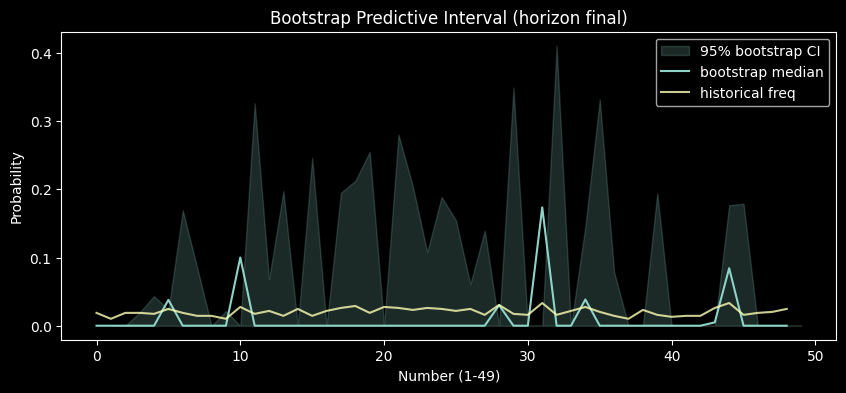

Bootstrap / PPC module completed (B= 200 )


In [9]:
# 8. Bootstrap / Posterior Predictive Check (Resample periods, rebuild rho_num → D_base, collect predictive distribution)
import numpy as np
import matplotlib.pyplot as plt

B = 200  # Number of bootstrap iterations (adjust according to computational power)
bootstrap_preds = np.zeros((B, nums))
rng = np.random.default_rng(2025)

for b_idx in range(B):
    # Resample period indices
    idxs = rng.integers(low=0, high=X.shape[0], size=X.shape[0])
    X_boot = X[idxs]
    # Recalculate rho_num_boot using safe_corrcoef (avoid zero-variance issues)
    rho_boot = safe_corrcoef(X_boot)
    # Rebuild D_base using est_alpha (if not estimated, use alpha)
    alpha_use = est_alpha if 'est_alpha' in globals() else alpha
    grid = np.arange(1, nums+1)
    D_b = np.zeros((nums, nums))
    for k in range(nums):
        for j in range(nums):
            if k == j:
                continue
            dist = (grid[k] - grid[j])**2
            rho_kj = rho_boot[k, j]
            w = np.exp(-dist / (2 * eta**2)) * (1 + alpha_use * abs(rho_kj))
            D_b[k, j] = -w
            D_b[k, k] += w
    # Initialize f0_boot as historical frequency of bootstrap data (full sample)
    f0_b = X_boot.sum(axis=0) / (6.0 * X_boot.shape[0])
    # Evolve to horizon
    f_cur = f0_b.copy()
    for m in range(predict_horizon):
        idx = min(m, len(b_norm)-1)
        k_use = est_kappa if 'est_kappa' in globals() else kappa
        D_t = D_b * (1 + k_use * b_norm[idx])
        f_next = f_cur + (D_t @ f_cur)
        f_next = np.maximum(f_next, 0)
        if f_next.sum() <= 0:
            f_next = np.ones_like(f_next) / len(f_next)
        else:
            f_next = f_next / f_next.sum()
        f_cur = f_next
    bootstrap_preds[b_idx] = f_cur

# Calculate 95% CI
lower = np.percentile(bootstrap_preds, 2.5, axis=0)
upper = np.percentile(bootstrap_preds, 97.5, axis=0)
median = np.percentile(bootstrap_preds, 50, axis=0)

# Plot: historical frequency and bootstrap interval
obs_counts = X.sum(axis=0)
obs_freq = obs_counts / obs_counts.sum()

plt.figure(figsize=(10,4))
plt.fill_between(np.arange(1, nums+1), lower, upper, color='C0', alpha=0.2, label='95% bootstrap CI')
plt.plot(median, label='bootstrap median', color='C0')
plt.plot(obs_freq, label='historical freq', color='C1', alpha=0.8)
plt.xlabel('Number (1-49)')
plt.ylabel('Probability')
plt.title('Bootstrap Predictive Interval (horizon final)')
plt.legend()
plt.show()

print('Bootstrap / PPC module completed (B=', B, ')')